**Project Title:**

DisasterGuard: AI-Powered Natural Disaster Prediction System

**Problem Statement:**

Natural disasters like floods, earthquakes, and wildfires pose serious threats to life and infrastructure. Accurate predictions are essential for timely preparation and risk reduction. This project aims to develop a machine learning system that predicts the most likely disaster for a given region based on historical, climatic, and geographic data.

**Description:**

“DisasterGuard” uses a dataset of 15 disaster types to build a multi-class classification model. Input features include location, climate data, and historical disaster records. The model predicts the likely disaster type and can optionally provide probabilities for all disaster types. The system can be deployed with a dashboard to help authorities and communities make informed decisions and prepare effectively.

In [71]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  # optional alternative
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Model saving/loading
import joblib

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Inline plots
%matplotlib inline


In [73]:
import pandas as pd


df = pd.read_csv("../data/Natural disaster.csv")
print("Dataset Shape:", df.shape)
display(df.head())




Dataset Shape: (16126, 45)


,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


In [75]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16126 entries, 0 to 16125
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        16126 non-null  int64  
 1   Seq                         16126 non-null  int64  
 2   Glide                       1581 non-null   object 
 3   Disaster Group              16126 non-null  object 
 4   Disaster Subgroup           16126 non-null  object 
 5   Disaster Type               16126 non-null  object 
 6   Disaster Subtype            13016 non-null  object 
 7   Disaster Subsubtype         1077 non-null   object 
 8   Event Name                  3861 non-null   object 
 9   Country                     16126 non-null  object 
 10  ISO                         16126 non-null  object 
 11  Region                      16126 non-null  object 
 12  Continent                   16126 non-null  object 
 13  Location                    143

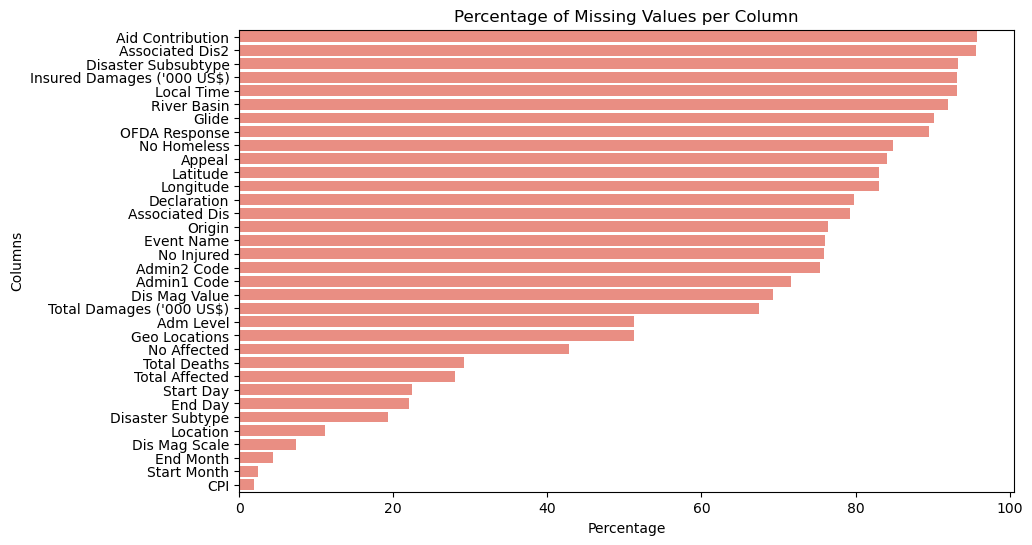

In [83]:
#EDA
#Missing Value Analysis
# Percentage of missing values per column
missing = df.isnull().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=missing.values, y=missing.index, color="salmon")
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Percentage")
plt.ylabel("Columns")
plt.show()


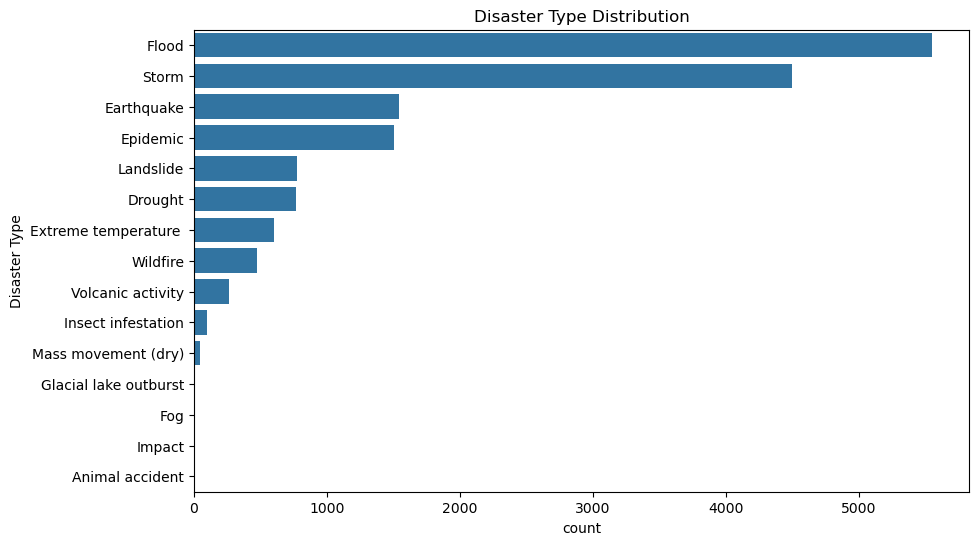

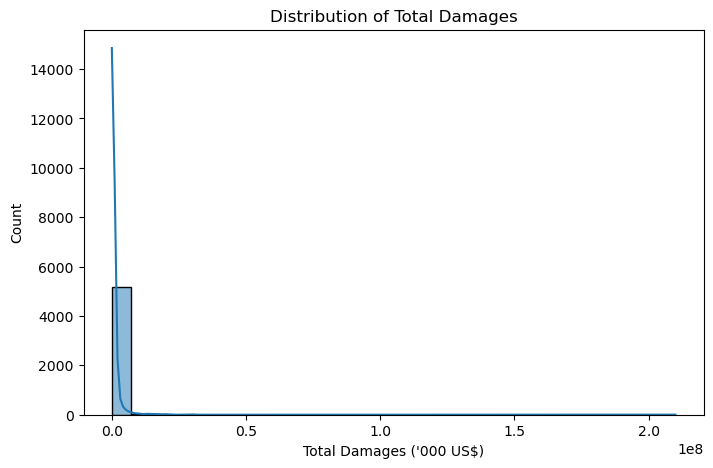

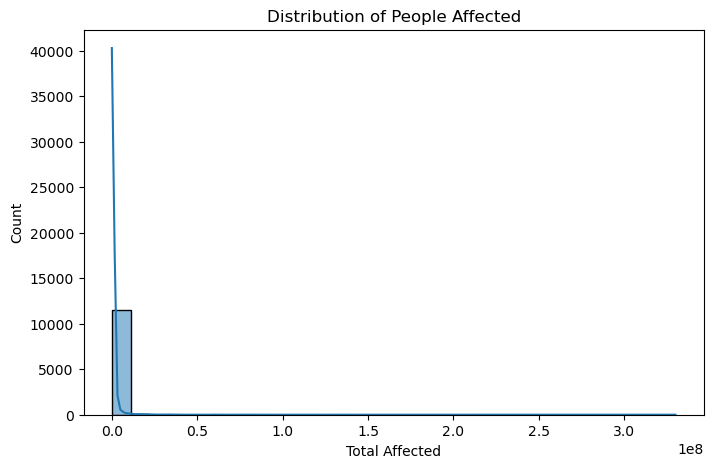

In [85]:
#Univariate Analysis
# Disaster Type Distribution
plt.figure(figsize=(10,6))
sns.countplot(y="Disaster Type", data=df, order=df["Disaster Type"].value_counts().index)
plt.title("Disaster Type Distribution")
plt.show()

# Histogram of Total Damages
plt.figure(figsize=(8,5))
sns.histplot(df["Total Damages ('000 US$)"].dropna(), bins=30, kde=True)
plt.title("Distribution of Total Damages")
plt.show()

# Histogram of People Affected
plt.figure(figsize=(8,5))
sns.histplot(df["Total Affected"].dropna(), bins=30, kde=True)
plt.title("Distribution of People Affected")
plt.show()


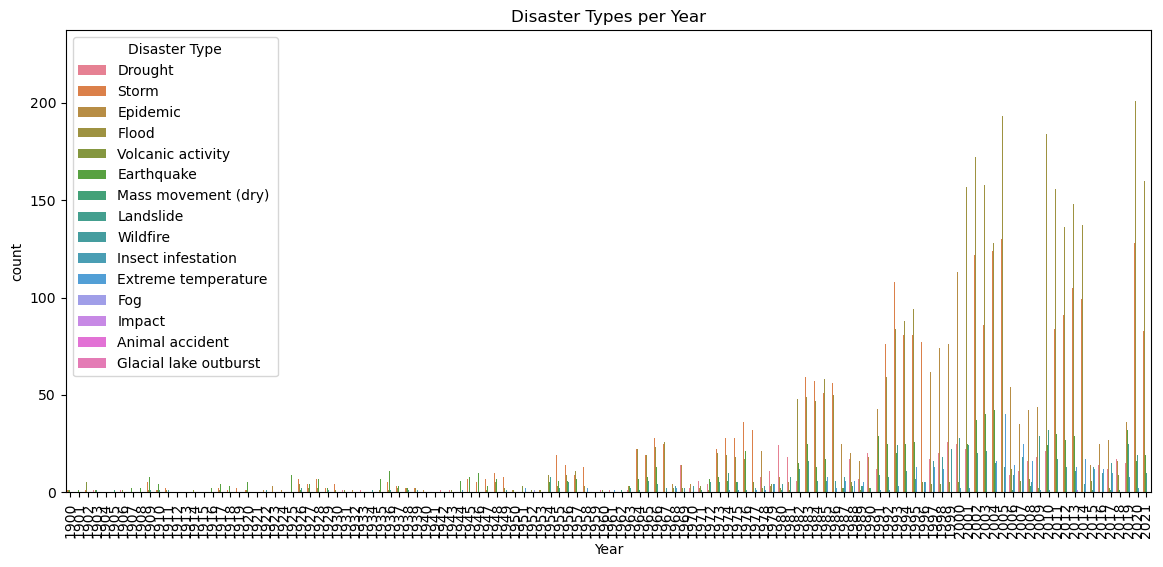

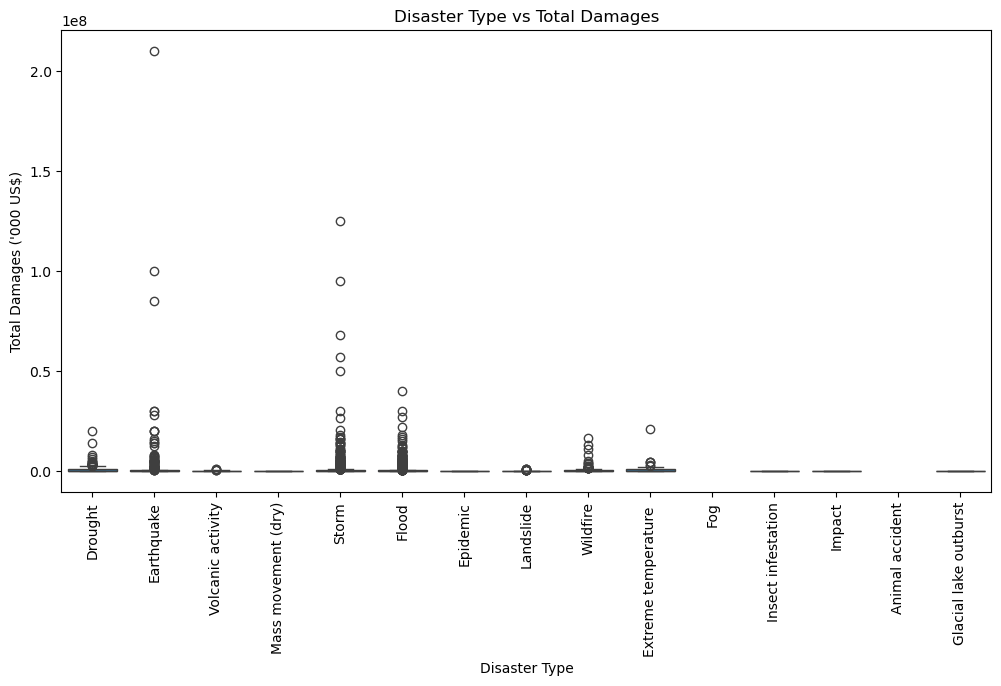

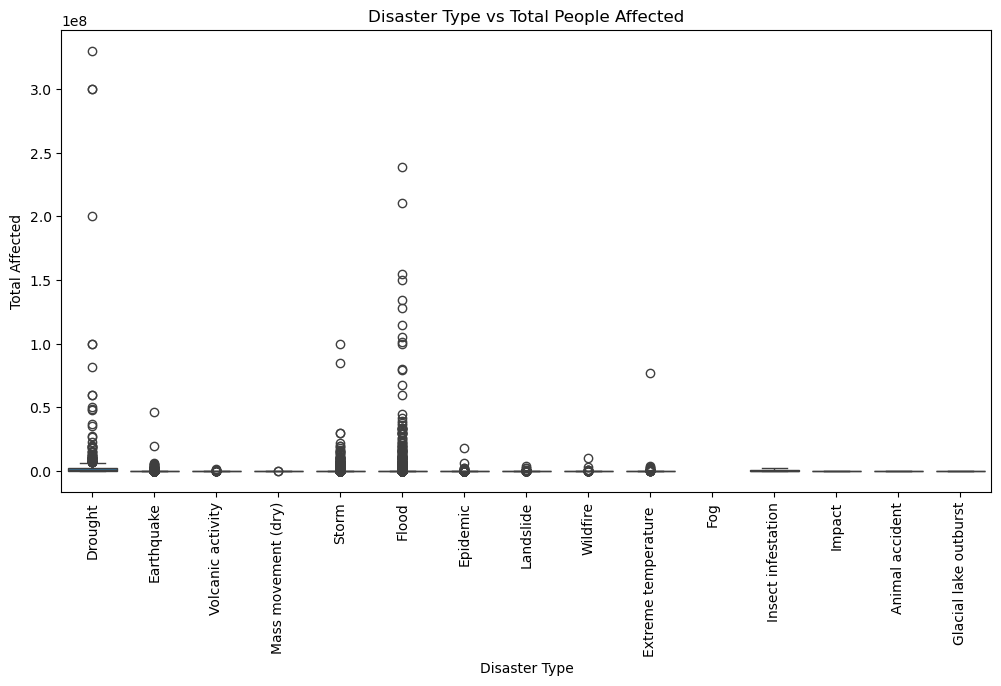

In [81]:
#Bivariate Analysis
# Year vs Disaster Type
plt.figure(figsize=(14,6))
sns.countplot(x="Year", hue="Disaster Type", data=df, order=sorted(df["Year"].unique()))
plt.title("Disaster Types per Year")
plt.xticks(rotation=90)
plt.show()

# Disaster Type vs Total Damages (Boxplot for spread)
plt.figure(figsize=(12,6))
sns.boxplot(x="Disaster Type", y="Total Damages ('000 US$)", data=df)
plt.title("Disaster Type vs Total Damages")
plt.xticks(rotation=90)
plt.show()

# Disaster Type vs People Affected
plt.figure(figsize=(12,6))
sns.boxplot(x="Disaster Type", y="Total Affected", data=df)
plt.title("Disaster Type vs Total People Affected")
plt.xticks(rotation=90)
plt.show()


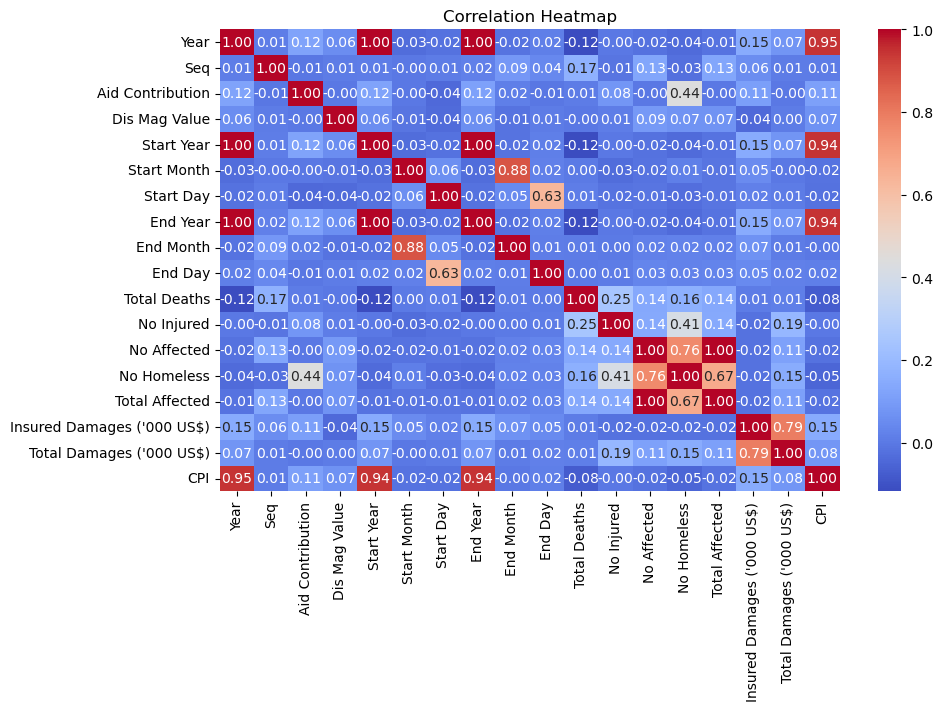

In [87]:
#Correlation Analysis
# Select only numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


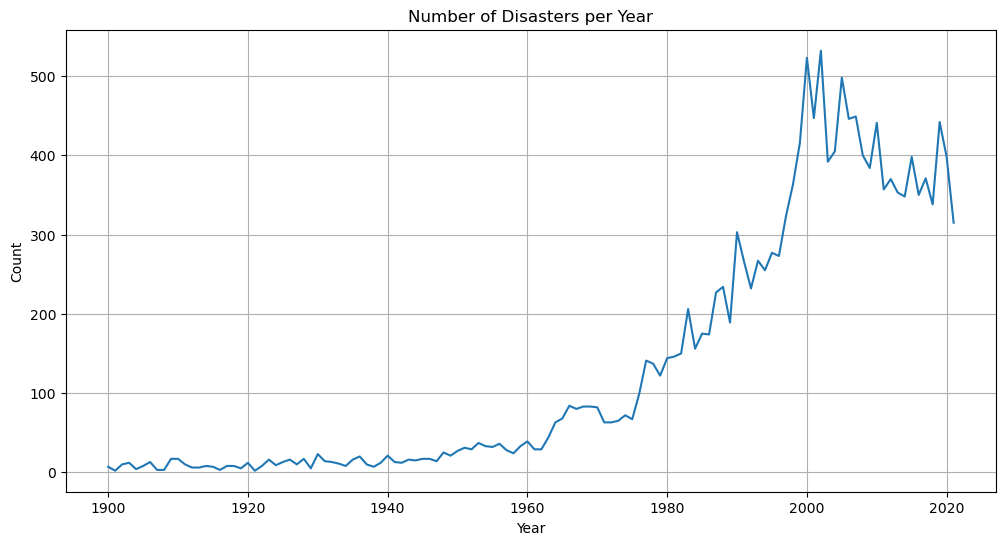

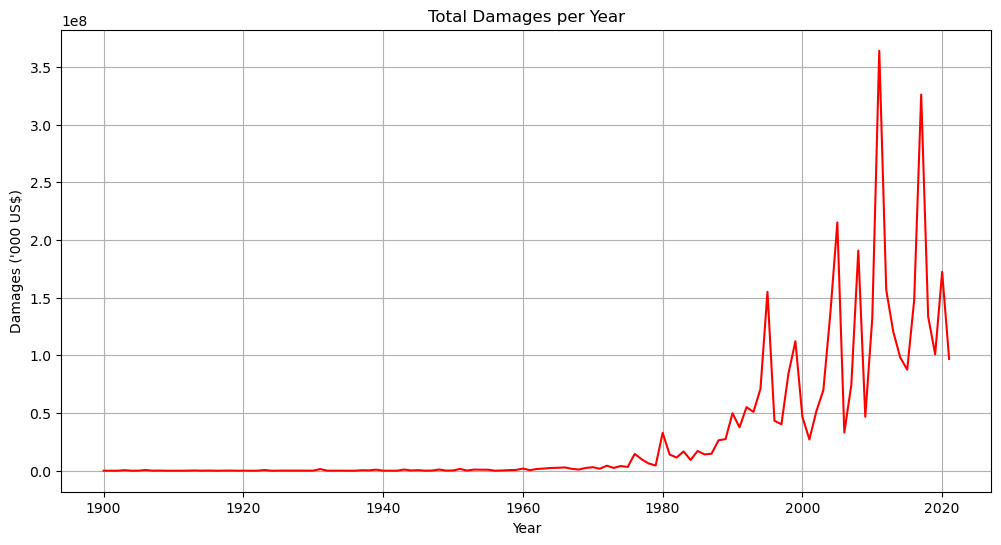

In [89]:
#Trend Analysis (Time Series)
# Disasters per year
yearly_counts = df.groupby("Year").size()

plt.figure(figsize=(12,6))
yearly_counts.plot(kind="line")
plt.title("Number of Disasters per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Yearly total damages
yearly_damages = df.groupby("Year")["Total Damages ('000 US$)"].sum()

plt.figure(figsize=(12,6))
yearly_damages.plot(kind="line", color="red")
plt.title("Total Damages per Year")
plt.xlabel("Year")
plt.ylabel("Damages ('000 US$)")
plt.grid(True)
plt.show()


In [91]:
#Preprocessing
# Drop irrelevant or mostly empty columns
drop_cols = ['Seq','Glide','Event Name','Geo Locations','Admin1 Code','Admin2 Code']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Fill missing numeric values with median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with mode
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical columns
label_enc = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = label_enc.fit_transform(df[col])

print("\nAfter preprocessing:")
display(df.head())



After preprocessing:


,Year,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Country,ISO,Region,Continent,...,End Day,Total Deaths,No Injured,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level
0,1900,0,1,1,6,10,31,45,20,0,...,16.0,11000.0,50.0,10000.0,3000.0,5965.0,172500.0,60000.0,3.221647,0
1,1900,0,1,1,6,10,89,92,18,2,...,16.0,1250000.0,50.0,10000.0,3000.0,5965.0,172500.0,60000.0,3.221647,0
2,1902,0,3,2,11,10,80,81,2,1,...,18.0,2000.0,50.0,10000.0,3000.0,5965.0,172500.0,25000.0,3.350513,0
3,1902,0,3,13,0,10,80,81,2,1,...,8.0,1000.0,50.0,10000.0,3000.0,5965.0,172500.0,60000.0,3.350513,0
4,1902,0,3,13,0,10,80,81,2,1,...,24.0,6000.0,50.0,10000.0,3000.0,5965.0,172500.0,60000.0,3.350513,0


Original dataset size: 16126
Filtered dataset size: 16123
Classes kept: [5, 12, 2, 3, 10, 1, 4, 14, 13, 9, 11, 7]

Feature Importances (higher = more important):
Year                        0.306100
Total Affected              0.280440
No Affected                 0.195776
Total Damages ('000 US$)    0.155180
No Homeless                 0.062504
dtype: float64


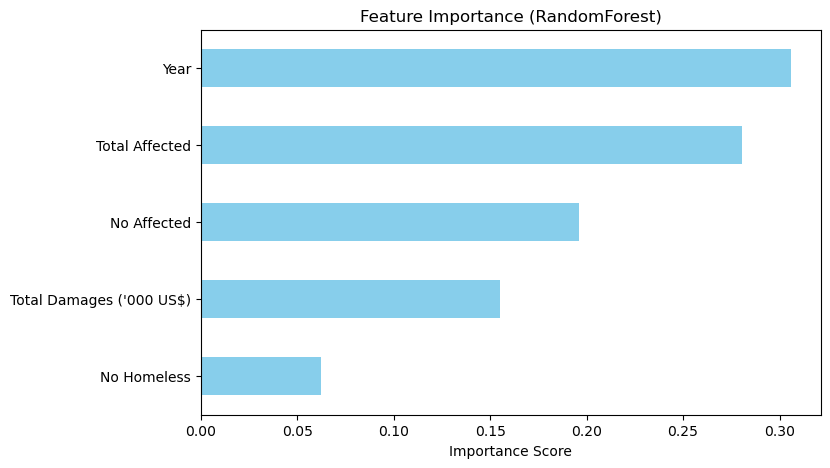


Selected Features: ['Year', 'Total Affected', 'No Affected']


In [99]:
#  Feature Selection 


class_counts = df["Disaster Type"].value_counts()
valid_classes = class_counts[class_counts > 1].index   # keep only classes with >= 2 samples
df_filtered = df[df["Disaster Type"].isin(valid_classes)]

print("Original dataset size:", len(df))
print("Filtered dataset size:", len(df_filtered))
print("Classes kept:", list(valid_classes))


features = ["Year", "Total Affected", "No Affected", 
            "No Homeless", "Total Damages ('000 US$)"]

X = df_filtered[features].fillna(0)   # Independent variables
y = df_filtered["Disaster Type"]      # Target variable


le = LabelEncoder()
y = le.fit_transform(y.astype(str))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


importances = pd.Series(model.feature_importances_, index=X.columns)


print("\nFeature Importances (higher = more important):")
print(importances.sort_values(ascending=False))


plt.figure(figsize=(8,5))
importances.sort_values().plot(kind="barh", color="skyblue")
plt.title("Feature Importance (RandomForest)")
plt.xlabel("Importance Score")
plt.show()


top_features = importances.sort_values(ascending=False).head(3).index
print("\nSelected Features:", list(top_features))


X_train_selected = X_train[top_features]
X_test_selected  = X_test[top_features]
